In [657]:
import os
import torch
import warnings
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from time import time
from torch import nn
from itertools import chain
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader
from IPython.core.display_functions import clear_output

In [658]:
device = "cpu"
convert = lambda x: x if x >= 150 else 0
convert = np.vectorize(convert)

In [659]:
warnings.filterwarnings("ignore")

In [660]:
if not os.path.isdir("raw_data"):
    os.chdir("../")

In [661]:
data = pd.read_csv("raw_data/db.csv", sep=";")

In [662]:
for i in dict(data.dtypes).items():
    if i[0] == "Дата":
        continue
    if i[1] == np.dtype('O'):
        data[i[0]] = data[i[0]].apply(lambda x: float(".".join(x.split(","))))

In [663]:
data.dtypes

Дата                                                       object
Выработка электроэнергии ТА гр.130                        float64
Отпуск тепла из ТО ТА гр.130                                int64
Удельный расход условного топлива на отпуск э/э гр.130    float64
Выработка электроэнергии ТА гр.90                         float64
Удельный расход тепла на выработку э/э ТА гр.130          float64
Удельный расход тепла на выработку э/э ТА гр.90           float64
Удельный расход условного топлива на отпуск э/э гр.90     float64
Расход пара в конденсатор ТА №3                           float64
Расход пара в конденсатор ТА №4                           float64
Расход пара в конденсатор ТА №5                           float64
Расход пара в конденсатор ТА №6                           float64
Расход пара в конденсатор ТА №7                           float64
Расход пара в конденсатор ТА №8                           float64
Расход свежего пара ТА №3                                   int64
Расход све

In [664]:
date = np.array([[0, 0, 0]], dtype=int)
for i in data["Дата"]:
    date = np.vstack([date, i.split("/")])

In [665]:
date = date[1:]

In [666]:
data["months"] = date[:, 0]
data.months = data.months.apply(int)

In [667]:
data["day"] = date[:, 1]
data.day = data.day.apply(int)

In [668]:
data["years"] = date[:, 2]
data.years = data.years.apply(int)

In [669]:
data = data.drop(["Дата"], axis=1)

In [670]:
fuel_columns = [
    "Удельный расход условного топлива на отпуск э/э гр.130",
    "Удельный расход условного топлива на отпуск э/э гр.90",
    "Расход топлива в условном исчислении КА №10",
    "Расход топлива в условном исчислении КА №11",
    "Расход топлива в условном исчислении КА №12",
    "Расход топлива в условном исчислении КА №5",
    "Расход топлива в условном исчислении КА №6",
    "Расход топлива в условном исчислении КА №7",
    "Расход топлива в условном исчислении КА №8",
    "Расход топлива в условном исчислении КА №9"
]

In [671]:
target = next(iter(fuel_columns))

In [672]:
def get_columns_without_tagrets(_target: str):
    return list(set(fuel_columns) - {_target})

In [673]:
X = data.drop(get_columns_without_tagrets(target), axis=1)

In [674]:
y = data[target]

In [675]:
input_shape = X.shape[1]

In [933]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_shape, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc4(x)
        return x

In [934]:
def predict(_model, prediction_data):
    _model.eval()
    if isinstance(prediction_data, list):
        Y_pred = [_model(X_batch.double()) for X_batch in prediction_data]
    else:
        Y_pred = [_model(X_batch) for X_batch, _ in prediction_data]
    return Y_pred

In [935]:
def score_model(_model, metric, prediction_data):
    _model.eval()
    scores = 0
    for X_batch, Y_label in prediction_data:
        Y_pred = _model(X_batch)
        scores += metric(
            Y_pred.detach().numpy(), Y_label.detach().numpy()
        ).mean().item()

    return scores / len(prediction_data)

In [936]:
def train(_model, opt, loss_function, epochs, data_tr, data_val, scoring=r2_score):
    loses = []
    scores = {
        "train": [],
        "val": []
    }
    # scheduler = torch.optim.lr_scheduler.StepLR(opt, 30)
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        _model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()
            Y_pred = _model(X_batch)
            model_loss = loss_function(Y_batch, Y_pred)
            model_loss.backward()
            opt.step()

            avg_loss += model_loss / len(data_tr)
        # scheduler.step(model_loss)
        toc = time()

        _model.eval()

        scores["val"].append(
            score_model(_model, scoring, data_val)
        )
        scores["train"].append(
            score_model(_model, scoring, data_tr)
        )
        clear_output(wait=True)
        clear_output(wait=True)
        plt.plot(scores["val"], label="val")
        plt.plot(scores["train"], label="train")
        plt.legend(title="type")
        plt.show()
        print('loss:', avg_loss, toc - tic)
        loses.append(float(avg_loss.detach()))
    return loses, scores

In [937]:
X_train = torch.tensor(X[:900].to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y[:900].to_numpy(), dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X[900:].to_numpy(), dtype=torch.float32)
y_val = torch.tensor(y[900:].to_numpy(), dtype=torch.float32).reshape(-1, 1)

train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=16)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle=True, batch_size=16)

In [938]:
model = SimpleNN()
loss_fn = nn.MSELoss()
optim = torch.optim.RMSprop(model.parameters(), 1e-5)

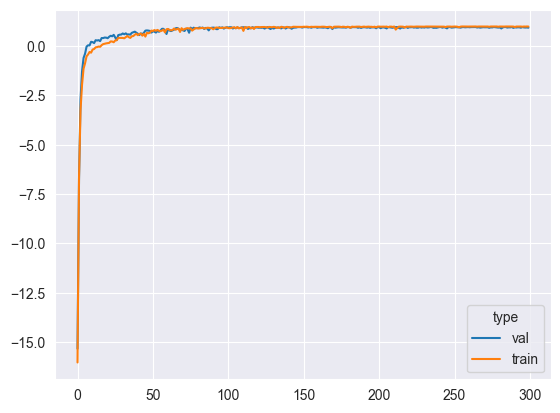

loss: tensor(128.6503, grad_fn=<AddBackward0>) 0.01600790023803711


In [939]:
loss, score = train(model, optim, loss_fn, 300, train_loader, val_loader)

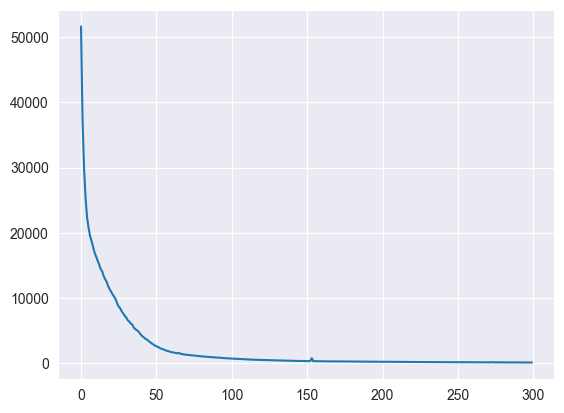

In [940]:
plt.plot(loss);

In [941]:
X_test = torch.tensor(X.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y.to_numpy(), dtype=torch.float32)
test_loader = DataLoader(list(zip(X_test, y_test)))

predictions = predict(model, test_loader)
predictions = list(map(lambda x: x.detach().numpy(), predictions))

In [942]:
predictions = list(map(lambda x: x.reshape(-1).tolist(), predictions))

In [943]:
predictions = np.array(list(chain.from_iterable(predictions)))

In [944]:
predictions = convert(predictions)

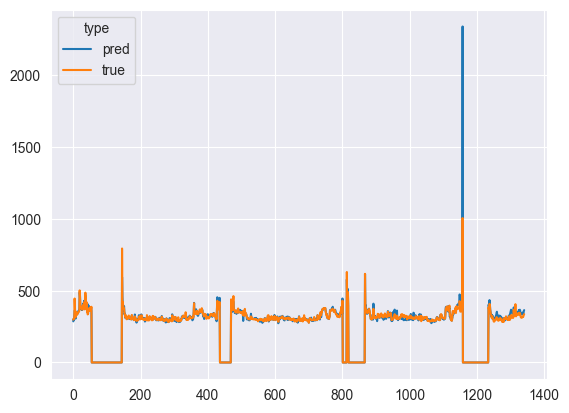

In [945]:
plt.plot(predictions, label="pred")
plt.plot(y.to_numpy(), label="true")
plt.legend(title="type");

In [946]:
r2_score(y.to_numpy(), predictions)

0.9163640051067284

In [947]:
len(data.drop(get_columns_without_tagrets(target), axis=1).columns)

36

In [948]:
out_shape = 3

In [949]:
X_new = np.array([[0] * 36])
y_new = np.array([[0] * out_shape])

In [950]:
for i in range(len(data.drop(get_columns_without_tagrets(target), axis=1).values) - out_shape):
    concat_x_data = data.drop(
        get_columns_without_tagrets(target), axis=1
    ).iloc[i].values
    concat_y_data = np.stack(
        [
            data.drop(
                get_columns_without_tagrets(target), axis=1
            ).iloc[i + 1][target],
            data.drop(
                get_columns_without_tagrets(target), axis=1
            ).iloc[i + 2][target],
            data.drop(
                get_columns_without_tagrets(target), axis=1
            ).iloc[i + 3][target],
            # data.drop(
            #     get_columns_without_tagrets(target), axis=1
            # ).iloc[i + 4][target]
        ]
    )

    X_new = np.append(X_new, [concat_x_data], axis=0)
    y_new = np.append(y_new, [concat_y_data], axis=0)

In [951]:
X_new = X_new[1:]
y_new = y_new[1:]

In [952]:
input_shape = X.shape[1]
output_shape = 1 if len(y.shape) == 1 else y.shape[1]

In [954]:
class SimpleNN2(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleNN2, self).__init__()
        self.fc1 = nn.Linear(input_shape, 64)
        self.fc2 = nn.Linear(64, 64)
        # self.fc3 = nn.Linear(128, 128)
        # self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(64, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [955]:
X_train = torch.tensor(X_new[:900], dtype=torch.float32)
y_train = torch.tensor(y_new[:900], dtype=torch.float32)
X_val = torch.tensor(X_new[900:], dtype=torch.float32)
y_val = torch.tensor(y_new[900:], dtype=torch.float32)
train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=16)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle=True, batch_size=16)

In [967]:
model = SimpleNN2()
loss_fn = nn.MSELoss()
optim = torch.optim.RMSprop(model.parameters(), 1e-5)

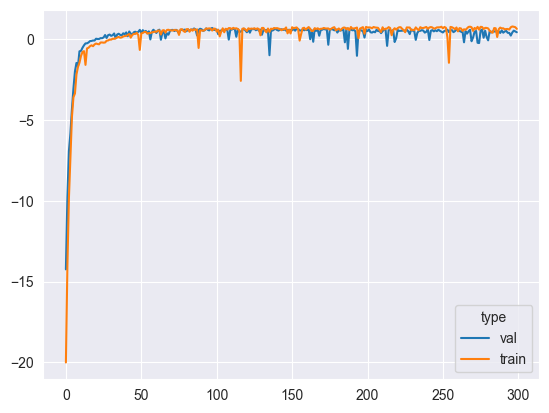

loss: tensor(3062.1401, grad_fn=<AddBackward0>) 0.017058134078979492


In [968]:
loss, score = train(model, optim, loss_fn, 300, train_loader, val_loader)

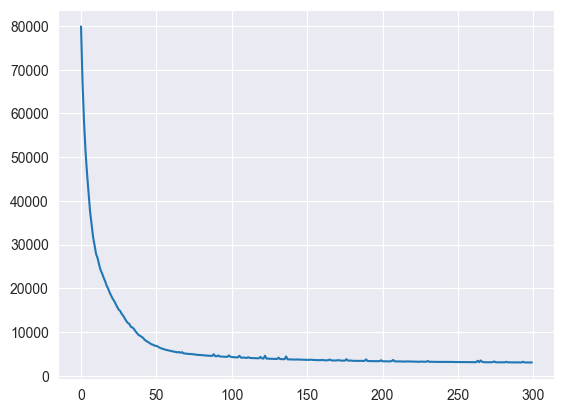

In [969]:
plt.plot(loss);

In [970]:
X_test = torch.tensor(X_new, dtype=torch.float32)
y_test = torch.tensor(y_new, dtype=torch.float32)
test_loader = DataLoader(list(zip(X_test, y_test)))

predictions = predict(model, test_loader)
predictions = list(map(lambda x: list(convert(x.detach().numpy()[0])), predictions))

In [971]:
# predictions = np.array(list(chain.from_iterable(predictions)))

In [972]:
difference = np.array([[0] * 3])
for pred, real in zip(predictions, y_test):
    # print(f"difference: {real - torch.tensor(pred)}")
    difference = np.append(difference, [(real - torch.tensor(pred)).numpy()], axis=0)

In [973]:
difference = difference[1:]

In [974]:
r2_score(y_test, predictions)

0.7258659379788656